In [57]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [211]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

In [ ]:
count = 0
for dirname, _, filenames in os.walk('./competition_data/train/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        count += 1

In [39]:
# Set up image parameters and matrix to hold all image data
imageWidth = 256
imageHeight = 256
numTrain = count//2

imagex = np.zeros(([numTrain,imageWidth, imageHeight,1]), dtype = np.float32)
imagey = np.zeros(([numTrain,imageWidth, imageHeight,1]), dtype = np.float32)

In [40]:
imagex.shape

(4000, 256, 256, 1)

In [142]:
# load images

folder= "./competition_data/train/images/"
image_names=os.listdir(folder)
count = 0
for filename in image_names:
    img = tf.keras.preprocessing.image.load_img(folder+filename,grayscale=True, target_size=(imageWidth, imageHeight))
          
    x=tf.keras.preprocessing.image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    imagex[count] = images/255.0
    count += 1

In [146]:
# load masks

folder= "./competition_data/train/masks/"
image_names=os.listdir(folder)
count = 0
for filename in image_names:
    mask = tf.keras.preprocessing.image.load_img(folder+filename,grayscale=True, target_size=(imageWidth, imageHeight))
          
    y=tf.keras.preprocessing.image.img_to_array(mask)
    y=np.expand_dims(y, axis=0)
    images = np.vstack([y])
    imagey[count] = images/65535.0
    count += 1

In [79]:
imagex.shape

(4000, 256, 256, 1)

In [143]:
x.shape

(1, 256, 256, 1)

In [145]:
x.max()

255.0

In [233]:
y.max()

65535.0

In [80]:
imagey.shape

(4000, 256, 256, 1)

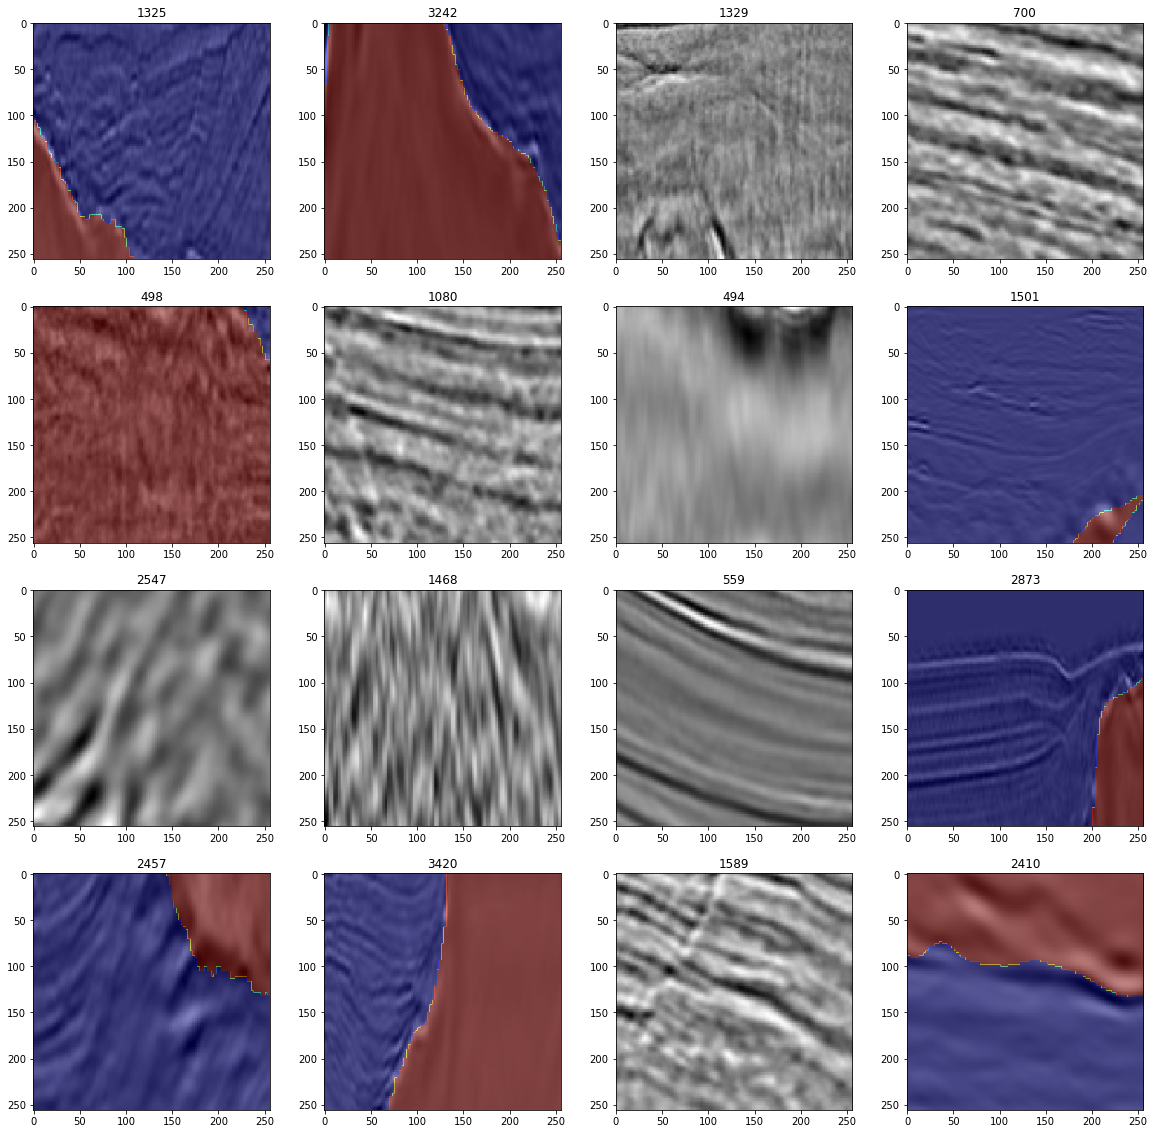

In [147]:
# visualize the input images
fig, axes = plt.subplots(4,4,figsize=(20,20))

for i, ax in enumerate(axes.ravel()):
    idx = random.randint(0, len(imagex))
    mask = imagey[idx].max() > 0 # salt indicator
    
    ax.imshow(imagex[idx,:],cmap='gray',interpolation = 'bilinear')
    if mask:
        ax.imshow(imagey[idx,:], cmap='jet',alpha=0.5)
    ax.set_title(f'{idx}')

In [148]:
train_x, test_x, train_y, test_y = train_test_split(imagex, imagey, test_size=0.2,random_state=1)

In [150]:
train_y.max()

1.0

#### Model 1: Unet, No drop out, No batch Normalization

In [182]:
input_layer = Input(shape=(imageWidth,imageHeight,1))

def UnetA(input_layer, n_filters = 4, kernel_size=(3,3),strides=(2,2),activefun = 'relu',padding = 'same'):
    c1 = Conv2D(filters=n_filters, kernel_size=kernel_size, activation=activefun, padding=padding)(input_layer)
    c2 = Conv2D(filters=n_filters, kernel_size=kernel_size, activation=activefun, padding=padding)(c1)
    l = tf.keras.layers.MaxPool2D(strides=strides)(c2)
    
    c3 = Conv2D(filters=n_filters*2, kernel_size=kernel_size, activation=activefun, padding=padding)(l)
    c4 = Conv2D(filters=n_filters*2, kernel_size=kernel_size, activation=activefun, padding=padding)(c3)
    l = MaxPool2D(strides=strides)(c4)
    
    c5 = Conv2D(filters=n_filters*4, kernel_size=kernel_size, activation=activefun, padding=padding)(l)
    c6 = Conv2D(filters=n_filters*4, kernel_size=kernel_size, activation=activefun, padding=padding)(c5)
    l = MaxPool2D(strides=strides)(c6)
    
    c7 = Conv2D(filters=n_filters*8, kernel_size=kernel_size, activation=activefun, padding=padding)(l)
    c8 = Conv2D(filters=n_filters*8, kernel_size=kernel_size, activation=activefun, padding=padding)(c7)
    l = MaxPool2D(strides=strides)(c8)
    
    c9 = Conv2D(filters=n_filters*16, kernel_size=kernel_size, activation=activefun, padding=padding)(l)
    c10= Conv2D(filters=n_filters*16, kernel_size=kernel_size, activation=activefun, padding=padding)(c9)

    u1 = Conv2DTranspose(filters=n_filters*8, kernel_size=kernel_size, strides = strides, padding = 'same')(c10)
    u1 = concatenate ([u1,c8])
    c11 = Conv2D(filters=n_filters*8, kernel_size=kernel_size, activation=activefun, padding='same')(u1)
    c12 = Conv2D(filters=n_filters*8, kernel_size=kernel_size, activation=activefun, padding='same')(c11)
    
    u2 = Conv2DTranspose(filters=n_filters*4, kernel_size=kernel_size, strides = strides, padding = 'same')(c12)
    u2 = concatenate ([u2,c6])
    c13 = Conv2D(filters=n_filters*4, kernel_size=kernel_size, activation=activefun, padding='same')(u2)
    c14 = Conv2D(filters=n_filters*4, kernel_size=kernel_size, activation=activefun, padding='same')(c13)
    
    u3 = Conv2DTranspose(filters=n_filters*2, kernel_size=kernel_size, strides = strides, padding = 'same')(c14)
    u3 = concatenate ([u3,c4])
    c15 = Conv2D(filters=n_filters*2, kernel_size=kernel_size, activation=activefun, padding='same')(u3)
    c16 = Conv2D(filters=n_filters*2, kernel_size=kernel_size, activation=activefun, padding='same')(c15)
    
    u4 = Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides = strides, padding = 'same')(c16)
    u4 = concatenate ([u4,c2])
    c17 = Conv2D(filters=n_filters, kernel_size=kernel_size, activation=activefun, padding='same')(u4)
    c18 = Conv2D(filters=n_filters, kernel_size=kernel_size, activation=activefun, padding='same')(c17)
    
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(c18)
    
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [184]:
model = UnetA(input_layer, n_filters = 4, kernel_size=(3,3),strides=(2,2),activefun = 'relu',padding = 'same')
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=["accuracy"])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 4)  40          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 4)  148         conv2d_76[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 128, 128, 4)  0           conv2d_77[0][0]                  
_______________________________________________________________________________________

In [185]:
model.fit(train_x, train_y, epochs=5,batch_size=16)

Epoch 1/5
200/200 [==============================] - 284s 1s/step - loss: 0.6041 - accuracy: 0.7399
Epoch 2/5
200/200 [==============================] - 285s 1s/step - loss: 0.5265 - accuracy: 0.7544
Epoch 3/5
200/200 [==============================] - 298s 1s/step - loss: 0.4153 - accuracy: 0.7928
Epoch 4/5
200/200 [==============================] - 384s 2s/step - loss: 0.3713 - accuracy: 0.8350
Epoch 5/5
200/200 [==============================] - 313s 2s/step - loss: 0.3369 - accuracy: 0.8709


In [186]:
model.evaluate(test_x,test_y)

25/25 [==============================] - 17s 670ms/step - loss: 0.3192 - accuracy: 0.8715


[0.319173127412796, 0.8715439438819885]

In [187]:
y_pred = model.predict(test_x)

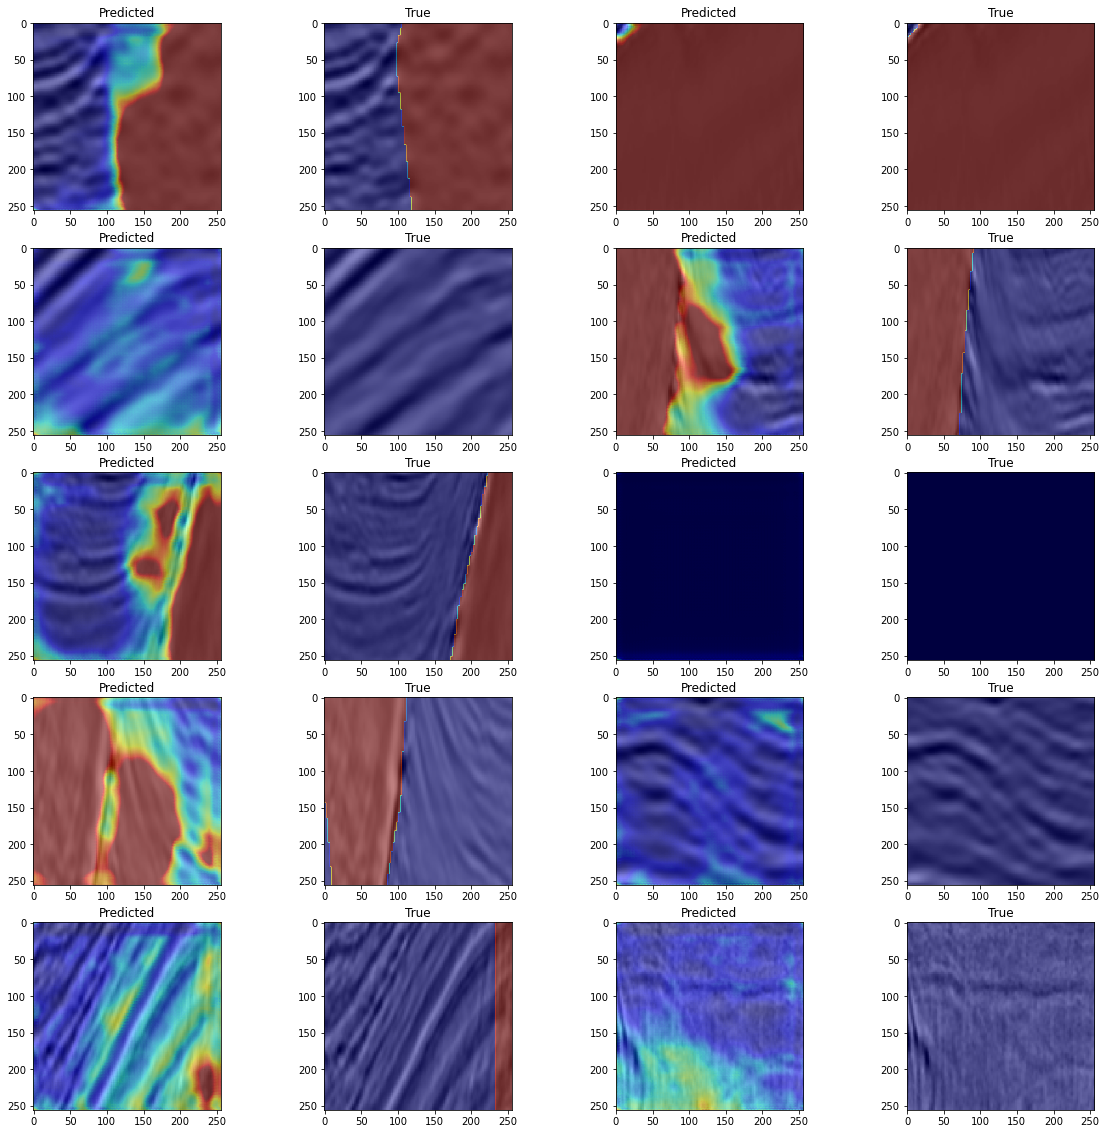

In [231]:
fig, axes = plt.subplots(5,4,figsize=(20,20))

for i in range(5):
    idx = random.randint(0, len(test_x))
    idx2 = random.randint(0, len(test_x))
    mask = test_y[idx].max() > 0 # salt indicator
    
    axes[i,0].imshow(test_x[idx,...,0],cmap='gray')
    axes[i,0].imshow(y_pred[idx,...,0], cmap='jet', alpha= 0.5)
    axes[i,0].set_title('Predicted')

    axes[i,1].imshow(test_x[idx,...,0],cmap='gray')
    axes[i,1].imshow(test_y[idx,...,0], cmap='jet', alpha= 0.5)
    axes[i,1].set_title('True')
    
    axes[i,2].imshow(test_x[idx2,...,0],cmap='gray')
    axes[i,2].imshow(y_pred[idx2,...,0], cmap='jet', alpha= 0.5)
    axes[i,2].set_title('Predicted')

    axes[i,3].imshow(test_x[idx2,...,0],cmap='gray')
    axes[i,3].imshow(test_y[idx2,...,0], cmap='jet', alpha= 0.5)
    axes[i,3].set_title('True')

#### Model 2: Unet, with drop out & batch Normalization

In [192]:
input_layer = Input(shape=(imageWidth,imageHeight,1))

def eachBlock(input_layer, n_filters,kernel_size, strides, activefun, padding,dropout, batchnorm):
    
    # first layer
    c1 = Conv2D(filters = n_filters, kernel_size = kernel_size,  padding=padding)(input_layer)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    c1 = Activation(activefun)(c1)

    # second layer
    c2 = Conv2D(filters = n_filters, kernel_size = kernel_size, padding=padding)(c1)
    if batchnorm:
        c2 = BatchNormalization()(c2)
    c2 = Activation(activefun)(c2)
    return c2

def UnetB(input_layer, n_filters = 4, kernel_size=(3,3), strides=(2,2), activefun = 'relu',padding = 'same', \
          dropout = 0.1, batchnorm = True):
    
    # Encoder
    c1 = eachBlock(input_layer, n_filters, kernel_size, strides, activefun, padding, dropout, batchnorm)
    p1 = MaxPooling2D(strides=strides)(c1)
    p1 = Dropout(dropout)(p1)

    c2 = eachBlock(p1, n_filters*2, kernel_size, strides, activefun, padding, dropout, batchnorm)
    p2 = MaxPooling2D(strides=strides)(c2)
    p2 = Dropout(dropout)(p2)

    c3 = eachBlock(p2, n_filters*4, kernel_size, strides, activefun, padding, dropout, batchnorm)
    p3 = MaxPooling2D(strides=strides)(c3)
    p3 = Dropout(dropout)(p3)

    c4 = eachBlock(p3, n_filters*8, kernel_size, strides, activefun, padding, dropout, batchnorm)
    p4 = MaxPooling2D(strides=strides)(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = eachBlock(p4, n_filters*16, kernel_size, strides, activefun, padding, dropout, batchnorm)
        
    # decoder
    u1 = Conv2DTranspose(filters=n_filters*8, kernel_size=kernel_size, strides = strides, padding = 'same')(c5)
    u1 = concatenate ([u1,c4])
    u1 = Dropout(dropout)(u1)
    c6 = eachBlock(u1, n_filters*8, kernel_size, strides, activefun, padding, dropout, batchnorm)
    
    u2 = Conv2DTranspose(filters=n_filters*4, kernel_size=kernel_size, strides = strides, padding = 'same')(c6)
    u2 = concatenate ([u2,c3])
    c7 = eachBlock(u2, n_filters*4, kernel_size, strides, activefun, padding, dropout, batchnorm)
    
    u3 = Conv2DTranspose(filters=n_filters*2, kernel_size=kernel_size, strides = strides, padding = 'same')(c7)
    u3 = concatenate ([u3,c2])
    c8 = eachBlock(u3, n_filters*2, kernel_size, strides, activefun, padding, dropout, batchnorm)
    
    u4 = Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides = strides, padding = 'same')(c8)
    u4 = concatenate ([u4,c1])
    c9 = eachBlock(u4, n_filters, kernel_size, strides, activefun, padding, dropout, batchnorm)
    
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [212]:
model2 = UnetB(input_layer, n_filters = 4, kernel_size=(3,3),strides=(2,2),activefun = 'relu',padding = 'same',dropout=0.1,batchnorm=True)
model2.summary()
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=["accuracy"])

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 4)  40          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 4)  16          conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 4)  0           batch_normalization_18[0][0]     
______________________________________________________________________________________

In [194]:
model2.fit(train_x, train_y, epochs=5,batch_size=16)

Epoch 1/5
200/200 [==============================] - 525s 3s/step - loss: 0.4795 - accuracy: 0.8279
Epoch 2/5
200/200 [==============================] - 516s 3s/step - loss: 0.3668 - accuracy: 0.8700
Epoch 3/5
200/200 [==============================] - 647s 3s/step - loss: 0.3197 - accuracy: 0.8810
Epoch 4/5
200/200 [==============================] - 633s 3s/step - loss: 0.3021 - accuracy: 0.8835
Epoch 5/5
200/200 [==============================] - 544s 3s/step - loss: 0.2870 - accuracy: 0.8885


In [195]:
model2.evaluate(test_x,test_y)

25/25 [==============================] - 15s 614ms/step - loss: 0.4957 - accuracy: 0.8374


[0.49566543102264404, 0.8373548984527588]

In [196]:
y_pred2 = model2.predict(test_x)

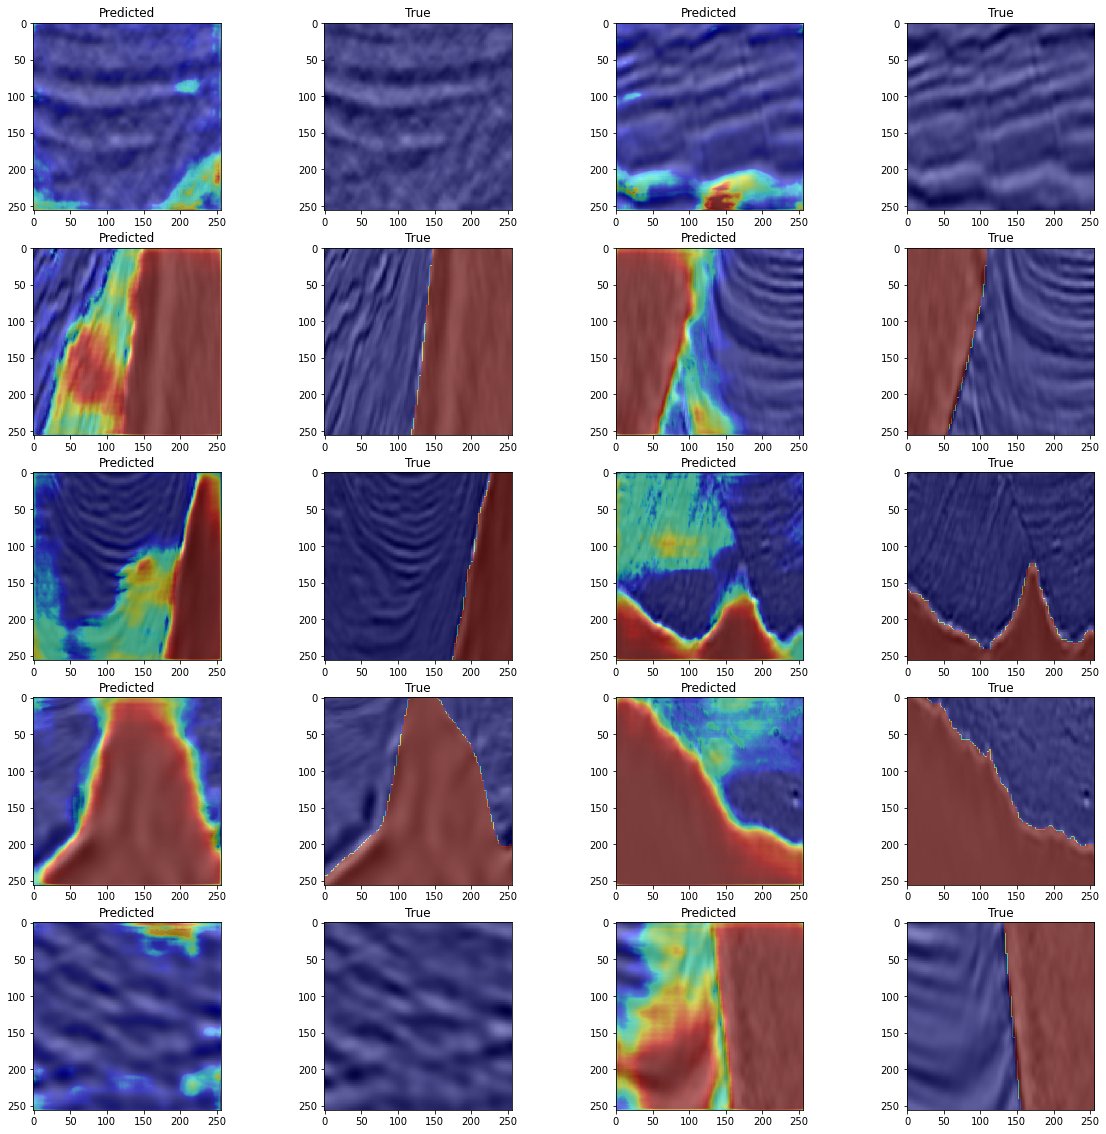

In [229]:
fig, axes = plt.subplots(5,4,figsize=(20,20))

for i in range(5):
    idx = random.randint(0, len(test_x))
    idx2 = random.randint(0, len(test_x))
    mask = test_y[idx].max() > 0 # salt indicator
    
    axes[i,0].imshow(test_x[idx,:],cmap='gray')
    axes[i,0].imshow(y_pred2[idx,:], cmap='jet', alpha= 0.5)
    axes[i,0].set_title('Predicted')

    axes[i,1].imshow(test_x[idx,:],cmap='gray')
    axes[i,1].imshow(test_y[idx,:], cmap='jet', alpha= 0.5)
    axes[i,1].set_title('True')
    
    axes[i,2].imshow(test_x[idx2,:],cmap='gray')
    axes[i,2].imshow(y_pred2[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,2].set_title('Predicted')

    axes[i,3].imshow(test_x[idx2,:],cmap='gray')
    axes[i,3].imshow(test_y[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,3].set_title('True')

In [213]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [214]:
results2 = model2.fit(train_x, train_y, epochs=5,batch_size=16, callbacks=callbacks, validation_data=(test_x, test_y))

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.8165
Epoch 00001: val_loss improved from inf to 0.72623, saving model to model-tgs-salt.h5
200/200 [==============================] - 556s 3s/step - loss: 0.5060 - accuracy: 0.8165 - val_loss: 0.7262 - val_accuracy: 0.2576
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8738
Epoch 00002: val_loss improved from 0.72623 to 0.70932, saving model to model-tgs-salt.h5
200/200 [==============================] - 675s 3s/step - loss: 0.3710 - accuracy: 0.8738 - val_loss: 0.7093 - val_accuracy: 0.4885
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8825
Epoch 00003: val_loss improved from 0.70932 to 0.58985, saving model to model-tgs-salt.h5
200/200 [==============================] - 677s 3s/step - loss: 0.3158 - accuracy: 0.8825 - val_loss: 0.5899 - val_accuracy: 0.6790
Epoch 4/5
200/200 [==============================] - 

In [221]:
model2b = UnetB(input_layer, n_filters = 4, kernel_size=(3,3),strides=(2,2),activefun = 'relu',padding = 'same',dropout=0.1,batchnorm=True)
model2b.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=["accuracy"])

In [222]:
model2b.load_weights('model-tgs-salt.h5')

In [223]:
model2b.evaluate(test_x,test_y)

25/25 [==============================] - 17s 662ms/step - loss: 0.3595 - accuracy: 0.8403


[0.3595445156097412, 0.840312659740448]

In [224]:
y_pred2b = model2b.predict(test_x)

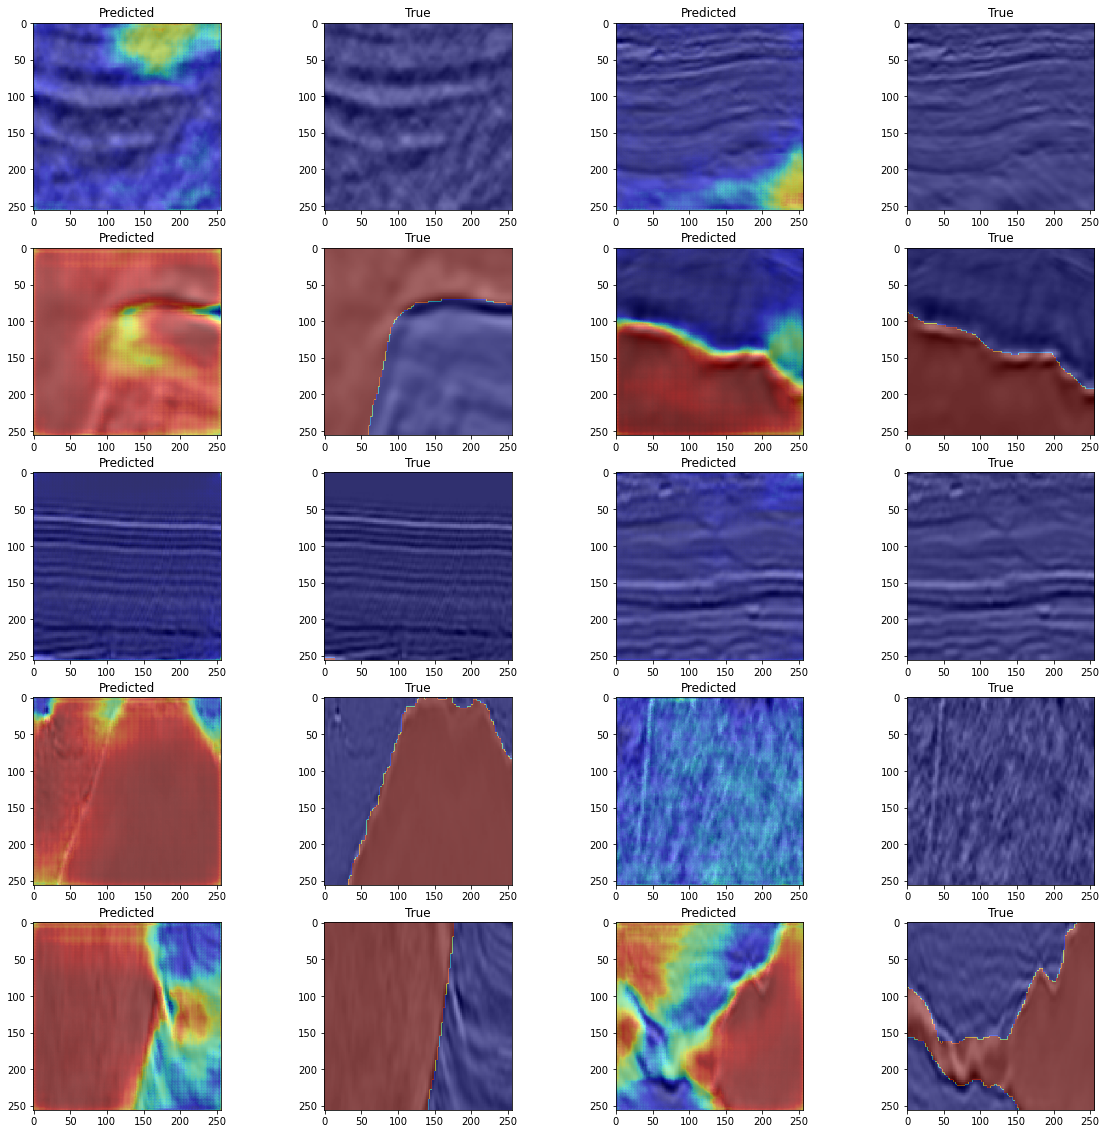

In [235]:
fig, axes = plt.subplots(5,4,figsize=(20,20))

for i in range(5):
    idx = random.randint(0, len(test_x))
    idx2 = random.randint(0, len(test_x))
    mask = test_y[idx].max() > 0 # salt indicator
    
    axes[i,0].imshow(test_x[idx,:],cmap='gray')
    axes[i,0].imshow(y_pred2b[idx,:], cmap='jet', alpha= 0.5)
    axes[i,0].set_title('Predicted')

    axes[i,1].imshow(test_x[idx,:],cmap='gray')
    axes[i,1].imshow(test_y[idx,:], cmap='jet', alpha= 0.5)
    axes[i,1].set_title('True')
    
    axes[i,2].imshow(test_x[idx2,:],cmap='gray')
    axes[i,2].imshow(y_pred2b[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,2].set_title('Predicted')

    axes[i,3].imshow(test_x[idx2,:],cmap='gray')
    axes[i,3].imshow(test_y[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,3].set_title('True')

#### Model 3: Transfer Learning

In [200]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [201]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm

from keras.models import Model

Segmentation Models: using `tf.keras` framework.


In [202]:
keras.backend.set_image_data_format('channels_last')

In [203]:
model3 = sm.Unet('resnet34', encoder_weights='imagenet', encoder_freeze=True)
model3.summary()



Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
______________________________________________________________________________________

In [204]:
l1 = Conv2D(3, (1, 1))(input_layer)  ## map N channels data to 3 channels

out = model3(l1)

In [205]:
model3 = tf.keras.Model(input_layer, out)#, name=base_model.name)
model3.summary()
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=["accuracy"])

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 256, 256, 3)       6         
_________________________________________________________________
functional_13 (Functional)   (None, None, None, 1)     24456154  
Total params: 24,456,160
Trainable params: 3,167,066
Non-trainable params: 21,289,094
_________________________________________________________________


In [206]:
model3.fit(train_x, train_y, epochs=5,batch_size=16)

Epoch 1/5
200/200 [==============================] - 2560s 13s/step - loss: 0.3201 - accuracy: 0.8676
Epoch 2/5
200/200 [==============================] - 2408s 12s/step - loss: 0.2409 - accuracy: 0.9045
Epoch 3/5
200/200 [==============================] - 2136s 11s/step - loss: 0.2137 - accuracy: 0.9177
Epoch 4/5
200/200 [==============================] - 10326s 52s/step - loss: 0.1899 - accuracy: 0.9273
Epoch 5/5
200/200 [==============================] - 2592s 13s/step - loss: 0.1757 - accuracy: 0.9325


In [207]:
model3.evaluate(test_x,test_y)

25/25 [==============================] - 141s 6s/step - loss: 1.4994 - accuracy: 0.6872


[1.499448537826538, 0.6871761083602905]

In [208]:
y_pred3 = model3.predict(test_x)

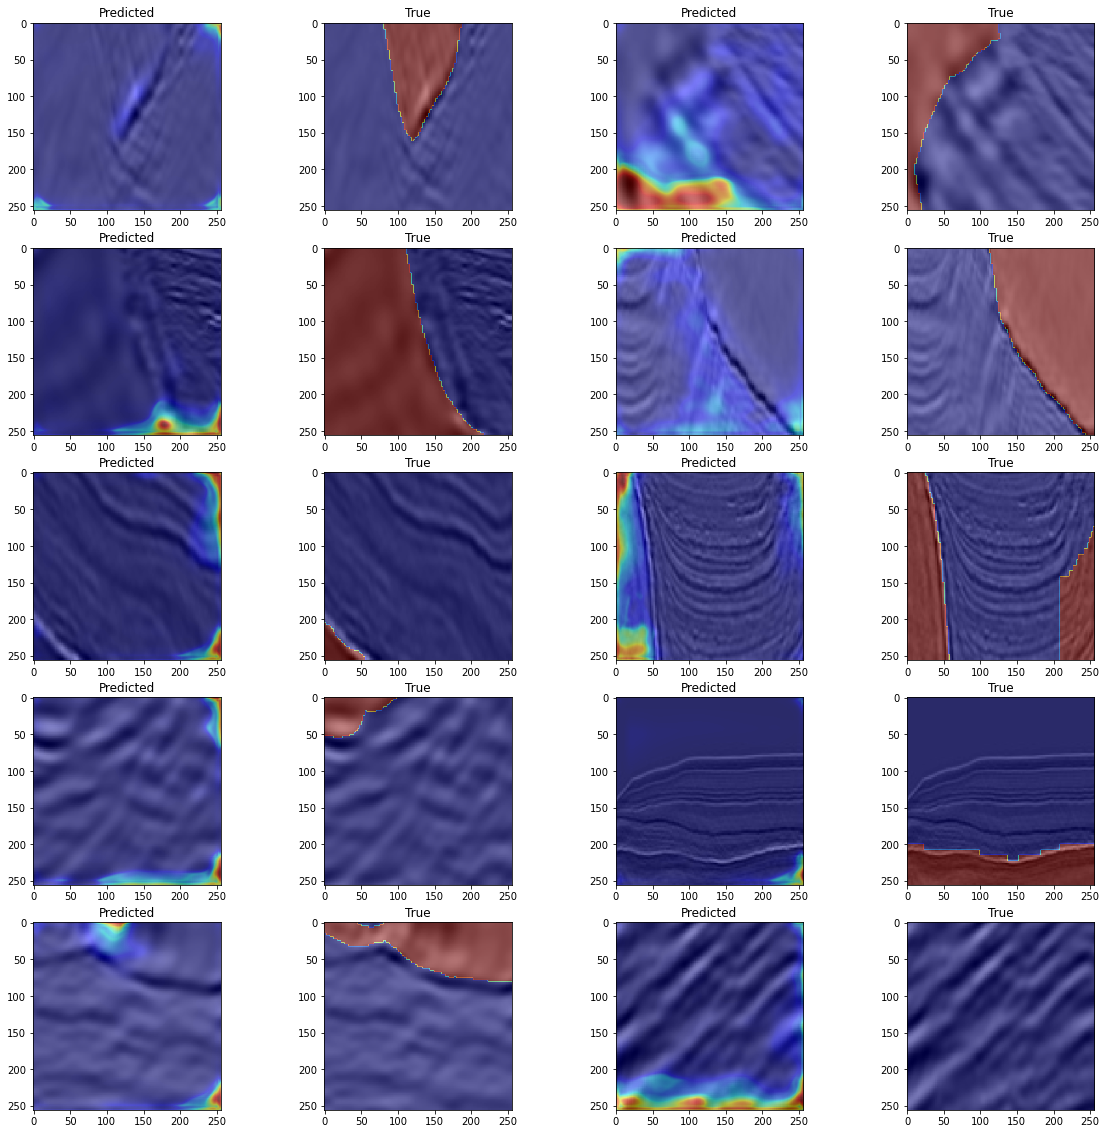

In [232]:
fig, axes = plt.subplots(5,4,figsize=(20,20))

for i in range(5):
    idx = random.randint(0, len(test_x))
    idx2 = random.randint(0, len(test_x))
    
    axes[i,0].imshow(test_x[idx,:],cmap='gray')
    axes[i,0].imshow(y_pred3[idx,:], cmap='jet', alpha= 0.5)
    axes[i,0].set_title('Predicted')

    axes[i,1].imshow(test_x[idx,:],cmap='gray')
    axes[i,1].imshow(test_y[idx,:], cmap='jet', alpha= 0.5)
    axes[i,1].set_title('True')
    
    axes[i,2].imshow(test_x[idx2,:],cmap='gray')
    axes[i,2].imshow(y_pred3[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,2].set_title('Predicted')

    axes[i,3].imshow(test_x[idx2,:],cmap='gray')
    axes[i,3].imshow(test_y[idx2,:], cmap='jet', alpha= 0.5)
    axes[i,3].set_title('True')    